In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(369744, 920)
(369744, 1)
validation
(50536, 920)
(50536, 1)
test
(51136, 920)
(51136, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 40s - loss: 0.0207 - STD: 2.1044e-04 - MAE: 0.1271

 4/37 [==>...........................] - ETA: 0s - loss: 0.0170 - STD: 1.9722e-04 - MAE: 0.1022 

 7/37 [====>.........................] - ETA: 0s - loss: 0.0157 - STD: 1.8421e-04 - MAE: 0.0960

11/37 [=======>......................] - ETA: 0s - loss: 0.0137 - STD: 2.0985e-04 - MAE: 0.0916

15/37 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 2.3894e-04 - MAE: 0.0884

19/37 [==============>...............] - ETA: 0s - loss: 0.0121 - STD: 2.5422e-04 - MAE: 0.0854

22/37 [================>.............] - ETA: 0s - loss: 0.0117 - STD: 2.7010e-04 - MAE: 0.0836

25/37 [===================>..........] - ETA: 0s - loss: 0.0113 - STD: 2.9418e-04 - MAE: 0.0827

28/37 [=====================>........] - ETA: 0s - loss: 0.0111 - STD: 3.2049e-04 - MAE: 0.0823

31/37 [========================>.....] - ETA: 0s - loss: 0.0108 - STD: 3.4323e-04 - MAE: 0.0815

34/37 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 3.6341e-04 - MAE: 0.0806

37/37 [==============================] - 3s 51ms/step - loss: 0.0105 - STD: 3.8525e-04 - MAE: 0.0799 - val_loss: 0.0087 - val_STD: 5.9963e-04 - val_MAE: 0.0681


Epoch 2/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0084 - STD: 7.0952e-04 - MAE: 0.0720

 4/37 [==>...........................] - ETA: 0s - loss: 0.0086 - STD: 7.7437e-04 - MAE: 0.0741

 7/37 [====>.........................] - ETA: 0s - loss: 0.0086 - STD: 8.2697e-04 - MAE: 0.0745

10/37 [=======>......................] - ETA: 0s - loss: 0.0086 - STD: 8.6948e-04 - MAE: 0.0743

13/37 [=========>....................] - ETA: 0s - loss: 0.0086 - STD: 9.1071e-04 - MAE: 0.0737

16/37 [===========>..................] - ETA: 0s - loss: 0.0086 - STD: 9.6562e-04 - MAE: 0.0735

19/37 [==============>...............] - ETA: 0s - loss: 0.0086 - STD: 0.0010 - MAE: 0.0736    

22/37 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 0.0011 - MAE: 0.0736

25/37 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 0.0012 - MAE: 0.0735

28/37 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.0013 - MAE: 0.0733

31/37 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.0014 - MAE: 0.0733

34/37 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.0016 - MAE: 0.0733

37/37 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0017 - MAE: 0.0732

37/37 [==============================] - 1s 23ms/step - loss: 0.0085 - STD: 0.0017 - MAE: 0.0732 - val_loss: 0.0084 - val_STD: 0.0033 - val_MAE: 0.0671


Epoch 3/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0082 - STD: 0.0039 - MAE: 0.0724

 4/37 [==>...........................] - ETA: 0s - loss: 0.0083 - STD: 0.0043 - MAE: 0.0719

 7/37 [====>.........................] - ETA: 0s - loss: 0.0083 - STD: 0.0048 - MAE: 0.0721

10/37 [=======>......................] - ETA: 0s - loss: 0.0082 - STD: 0.0054 - MAE: 0.0719

13/37 [=========>....................] - ETA: 0s - loss: 0.0082 - STD: 0.0060 - MAE: 0.0716

16/37 [===========>..................] - ETA: 0s - loss: 0.0081 - STD: 0.0068 - MAE: 0.0714

19/37 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.0078 - MAE: 0.0712

22/37 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.0089 - MAE: 0.0709

25/37 [===================>..........] - ETA: 0s - loss: 0.0079 - STD: 0.0103 - MAE: 0.0705

28/37 [=====================>........] - ETA: 0s - loss: 0.0078 - STD: 0.0118 - MAE: 0.0702

31/37 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0136 - MAE: 0.0698

34/37 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0155 - MAE: 0.0695

37/37 [==============================] - ETA: 0s - loss: 0.0076 - STD: 0.0174 - MAE: 0.0691

37/37 [==============================] - 1s 22ms/step - loss: 0.0076 - STD: 0.0174 - MAE: 0.0691 - val_loss: 0.0063 - val_STD: 0.0338 - val_MAE: 0.0575


Epoch 4/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0409 - MAE: 0.0640

 4/37 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0416 - MAE: 0.0643

 7/37 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0417 - MAE: 0.0639

10/37 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0417 - MAE: 0.0635

13/37 [=========>....................] - ETA: 0s - loss: 0.0065 - STD: 0.0419 - MAE: 0.0631

16/37 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0422 - MAE: 0.0626

19/37 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0429 - MAE: 0.0623

22/37 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0437 - MAE: 0.0619

25/37 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0445 - MAE: 0.0616

28/37 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0453 - MAE: 0.0614

31/37 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0460 - MAE: 0.0612

34/37 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0466 - MAE: 0.0609

37/37 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0471 - MAE: 0.0606

37/37 [==============================] - 1s 23ms/step - loss: 0.0061 - STD: 0.0471 - MAE: 0.0606 - val_loss: 0.0049 - val_STD: 0.0438 - val_MAE: 0.0513


Epoch 5/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0525 - MAE: 0.0575

 4/37 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0523 - MAE: 0.0574

 7/37 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0526 - MAE: 0.0569

10/37 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0527 - MAE: 0.0566

13/37 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0530 - MAE: 0.0564

16/37 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0533 - MAE: 0.0562

19/37 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0538 - MAE: 0.0561

22/37 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0542 - MAE: 0.0559

25/37 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0546 - MAE: 0.0558

28/37 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0550 - MAE: 0.0556

31/37 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0555 - MAE: 0.0554

34/37 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0559 - MAE: 0.0553

37/37 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0563 - MAE: 0.0553

37/37 [==============================] - 1s 23ms/step - loss: 0.0051 - STD: 0.0563 - MAE: 0.0553 - val_loss: 0.0043 - val_STD: 0.0502 - val_MAE: 0.0476


Epoch 6/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0049 - STD: 0.0613 - MAE: 0.0537

 4/37 [==>...........................] - ETA: 0s - loss: 0.0050 - STD: 0.0599 - MAE: 0.0544

 7/37 [====>.........................] - ETA: 0s - loss: 0.0049 - STD: 0.0596 - MAE: 0.0540

10/37 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0593 - MAE: 0.0539

13/37 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0593 - MAE: 0.0540

16/37 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0593 - MAE: 0.0538

19/37 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0594 - MAE: 0.0537

22/37 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0595 - MAE: 0.0537

25/37 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0595 - MAE: 0.0537

28/37 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0596 - MAE: 0.0538

31/37 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0595 - MAE: 0.0538

34/37 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0594 - MAE: 0.0538

37/37 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0594 - MAE: 0.0538

37/37 [==============================] - 1s 23ms/step - loss: 0.0049 - STD: 0.0594 - MAE: 0.0538 - val_loss: 0.0043 - val_STD: 0.0508 - val_MAE: 0.0482


Epoch 7/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0049 - STD: 0.0612 - MAE: 0.0547

 4/37 [==>...........................] - ETA: 0s - loss: 0.0048 - STD: 0.0600 - MAE: 0.0535

 7/37 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0599 - MAE: 0.0531

10/37 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0600 - MAE: 0.0530

13/37 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0602 - MAE: 0.0530

16/37 [===========>..................] - ETA: 0s - loss: 0.0048 - STD: 0.0604 - MAE: 0.0530

19/37 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0605 - MAE: 0.0529

22/37 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0606 - MAE: 0.0529

25/37 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0607 - MAE: 0.0528

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0608 - MAE: 0.0528

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0609 - MAE: 0.0528

34/37 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0610 - MAE: 0.0527

37/37 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0611 - MAE: 0.0526

37/37 [==============================] - 1s 23ms/step - loss: 0.0047 - STD: 0.0611 - MAE: 0.0526 - val_loss: 0.0041 - val_STD: 0.0517 - val_MAE: 0.0465


Epoch 8/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0634 - MAE: 0.0516

 4/37 [==>...........................] - ETA: 0s - loss: 0.0046 - STD: 0.0625 - MAE: 0.0520

 7/37 [====>.........................] - ETA: 0s - loss: 0.0046 - STD: 0.0622 - MAE: 0.0524

10/37 [=======>......................] - ETA: 0s - loss: 0.0047 - STD: 0.0621 - MAE: 0.0526

13/37 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0620 - MAE: 0.0525

16/37 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0621 - MAE: 0.0525

19/37 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0619 - MAE: 0.0524

22/37 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0619 - MAE: 0.0524

25/37 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0618 - MAE: 0.0523

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0618 - MAE: 0.0522

31/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0619 - MAE: 0.0522

34/37 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0620 - MAE: 0.0522

37/37 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0620 - MAE: 0.0521

37/37 [==============================] - 1s 22ms/step - loss: 0.0046 - STD: 0.0620 - MAE: 0.0521 - val_loss: 0.0040 - val_STD: 0.0520 - val_MAE: 0.0460


Epoch 9/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0046 - STD: 0.0640 - MAE: 0.0524

 4/37 [==>...........................] - ETA: 0s - loss: 0.0046 - STD: 0.0629 - MAE: 0.0519

 7/37 [====>.........................] - ETA: 0s - loss: 0.0046 - STD: 0.0626 - MAE: 0.0521

10/37 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0626 - MAE: 0.0521

13/37 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0625 - MAE: 0.0520

16/37 [===========>..................] - ETA: 0s - loss: 0.0046 - STD: 0.0624 - MAE: 0.0521

19/37 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0623 - MAE: 0.0521

22/37 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0622 - MAE: 0.0521

25/37 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0621 - MAE: 0.0523

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0621 - MAE: 0.0525

31/37 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0618 - MAE: 0.0529

34/37 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0614 - MAE: 0.0529

37/37 [==============================] - 1s 22ms/step - loss: 0.0048 - STD: 0.0610 - MAE: 0.0529 - val_loss: 0.0044 - val_STD: 0.0526 - val_MAE: 0.0518


Epoch 10/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0050 - STD: 0.0645 - MAE: 0.0571

 4/37 [==>...........................] - ETA: 0s - loss: 0.0047 - STD: 0.0589 - MAE: 0.0530

 7/37 [====>.........................] - ETA: 0s - loss: 0.0047 - STD: 0.0591 - MAE: 0.0529

10/37 [=======>......................] - ETA: 0s - loss: 0.0047 - STD: 0.0598 - MAE: 0.0528

13/37 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0603 - MAE: 0.0528

16/37 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0605 - MAE: 0.0526

19/37 [==============>...............] - ETA: 0s - loss: 0.0046 - STD: 0.0607 - MAE: 0.0524

22/37 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0610 - MAE: 0.0523

25/37 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0613 - MAE: 0.0521

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0615 - MAE: 0.0520

31/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0618 - MAE: 0.0520

34/37 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0619 - MAE: 0.0519

37/37 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0620 - MAE: 0.0518

37/37 [==============================] - 1s 22ms/step - loss: 0.0045 - STD: 0.0620 - MAE: 0.0518 - val_loss: 0.0040 - val_STD: 0.0512 - val_MAE: 0.0453


Epoch 11/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0046 - STD: 0.0637 - MAE: 0.0515

 4/37 [==>...........................] - ETA: 0s - loss: 0.0044 - STD: 0.0640 - MAE: 0.0510

 7/37 [====>.........................] - ETA: 0s - loss: 0.0044 - STD: 0.0638 - MAE: 0.0509

10/37 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0638 - MAE: 0.0510

13/37 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0638 - MAE: 0.0509

16/37 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0638 - MAE: 0.0508

19/37 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0638 - MAE: 0.0508

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0638 - MAE: 0.0508

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0639 - MAE: 0.0508

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0639 - MAE: 0.0508

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0640 - MAE: 0.0508

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0640 - MAE: 0.0508

37/37 [==============================] - 1s 21ms/step - loss: 0.0044 - STD: 0.0641 - MAE: 0.0508 - val_loss: 0.0041 - val_STD: 0.0507 - val_MAE: 0.0451


Epoch 12/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0502

 4/37 [==>...........................] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0506

 7/37 [====>.........................] - ETA: 0s - loss: 0.0044 - STD: 0.0647 - MAE: 0.0506

10/37 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0507

13/37 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0644 - MAE: 0.0506

16/37 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0507

19/37 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0646 - MAE: 0.0506

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0506

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0505

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0646 - MAE: 0.0505

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0646 - MAE: 0.0505

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0644 - MAE: 0.0506

37/37 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0644 - MAE: 0.0506

37/37 [==============================] - 1s 23ms/step - loss: 0.0044 - STD: 0.0644 - MAE: 0.0506 - val_loss: 0.0040 - val_STD: 0.0547 - val_MAE: 0.0479


Epoch 13/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0046 - STD: 0.0683 - MAE: 0.0531

 4/37 [==>...........................] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0515

 7/37 [====>.........................] - ETA: 0s - loss: 0.0044 - STD: 0.0637 - MAE: 0.0510

10/37 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0636 - MAE: 0.0510

13/37 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0635 - MAE: 0.0509

16/37 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0635 - MAE: 0.0508

19/37 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0637 - MAE: 0.0507

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0637 - MAE: 0.0506

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0640 - MAE: 0.0507

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0641 - MAE: 0.0506

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0643 - MAE: 0.0506

34/37 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0642 - MAE: 0.0505

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0643 - MAE: 0.0505

37/37 [==============================] - 1s 23ms/step - loss: 0.0043 - STD: 0.0643 - MAE: 0.0505 - val_loss: 0.0039 - val_STD: 0.0549 - val_MAE: 0.0466


Epoch 14/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0512

 4/37 [==>...........................] - ETA: 0s - loss: 0.0043 - STD: 0.0659 - MAE: 0.0503

 7/37 [====>.........................] - ETA: 0s - loss: 0.0045 - STD: 0.0647 - MAE: 0.0510

10/37 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0508

13/37 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0643 - MAE: 0.0508

16/37 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0508

19/37 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0509

22/37 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0508

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0507

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0641 - MAE: 0.0507

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0643 - MAE: 0.0506

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0644 - MAE: 0.0505

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0645 - MAE: 0.0505

37/37 [==============================] - 1s 22ms/step - loss: 0.0043 - STD: 0.0645 - MAE: 0.0505 - val_loss: 0.0039 - val_STD: 0.0544 - val_MAE: 0.0457


Epoch 15/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0502

 4/37 [==>...........................] - ETA: 0s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0500

 7/37 [====>.........................] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0498

10/37 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0497

13/37 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0658 - MAE: 0.0499

16/37 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0655 - MAE: 0.0499

19/37 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0654 - MAE: 0.0499

22/37 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0653 - MAE: 0.0504

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0648 - MAE: 0.0508

28/37 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0636 - MAE: 0.0520

31/37 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0530

34/37 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0535

37/37 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0601 - MAE: 0.0537

37/37 [==============================] - 1s 22ms/step - loss: 0.0049 - STD: 0.0601 - MAE: 0.0537 - val_loss: 0.0051 - val_STD: 0.0450 - val_MAE: 0.0583


Epoch 16/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0551 - MAE: 0.0629

 4/37 [==>...........................] - ETA: 0s - loss: 0.0051 - STD: 0.0491 - MAE: 0.0556

 7/37 [====>.........................] - ETA: 0s - loss: 0.0050 - STD: 0.0528 - MAE: 0.0552

10/37 [=======>......................] - ETA: 0s - loss: 0.0049 - STD: 0.0541 - MAE: 0.0542

13/37 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0559 - MAE: 0.0536

16/37 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0578 - MAE: 0.0533

19/37 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0585 - MAE: 0.0530

22/37 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0591 - MAE: 0.0527

25/37 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0597 - MAE: 0.0525

28/37 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0600 - MAE: 0.0523

31/37 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0603 - MAE: 0.0521

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0607 - MAE: 0.0519

37/37 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0611 - MAE: 0.0518

37/37 [==============================] - 1s 22ms/step - loss: 0.0045 - STD: 0.0611 - MAE: 0.0518 - val_loss: 0.0040 - val_STD: 0.0514 - val_MAE: 0.0447


Epoch 17/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0043 - STD: 0.0640 - MAE: 0.0495

 4/37 [==>...........................] - ETA: 0s - loss: 0.0043 - STD: 0.0655 - MAE: 0.0502

 7/37 [====>.........................] - ETA: 0s - loss: 0.0043 - STD: 0.0653 - MAE: 0.0500

10/37 [=======>......................] - ETA: 0s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0499

13/37 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0499

16/37 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0652 - MAE: 0.0499

19/37 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0499

22/37 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0499

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0499

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0498

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0654 - MAE: 0.0498

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0498

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0497

37/37 [==============================] - 1s 23ms/step - loss: 0.0042 - STD: 0.0655 - MAE: 0.0497 - val_loss: 0.0039 - val_STD: 0.0540 - val_MAE: 0.0454


Epoch 18/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0503

 4/37 [==>...........................] - ETA: 0s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0496

 7/37 [====>.........................] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0494

10/37 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0495

13/37 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0495

16/37 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0654 - MAE: 0.0495

19/37 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0496

22/37 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0495

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0495

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0495

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0658 - MAE: 0.0495

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0658 - MAE: 0.0494

37/37 [==============================] - 1s 22ms/step - loss: 0.0042 - STD: 0.0658 - MAE: 0.0494 - val_loss: 0.0040 - val_STD: 0.0527 - val_MAE: 0.0450


Epoch 19/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0487

 4/37 [==>...........................] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0490

 7/37 [====>.........................] - ETA: 0s - loss: 0.0041 - STD: 0.0668 - MAE: 0.0490

10/37 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0668 - MAE: 0.0492

13/37 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0667 - MAE: 0.0493

16/37 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0666 - MAE: 0.0494

19/37 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0665 - MAE: 0.0494

22/37 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0663 - MAE: 0.0495

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0661 - MAE: 0.0496

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0659 - MAE: 0.0496

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0659 - MAE: 0.0497

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0497

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0497

37/37 [==============================] - 1s 22ms/step - loss: 0.0042 - STD: 0.0657 - MAE: 0.0497 - val_loss: 0.0041 - val_STD: 0.0505 - val_MAE: 0.0451


Epoch 20/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0041 - STD: 0.0624 - MAE: 0.0488

 4/37 [==>...........................] - ETA: 0s - loss: 0.0042 - STD: 0.0639 - MAE: 0.0495

 7/37 [====>.........................] - ETA: 0s - loss: 0.0042 - STD: 0.0645 - MAE: 0.0496

10/37 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0647 - MAE: 0.0496

13/37 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0497

16/37 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0496

19/37 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0656 - MAE: 0.0495

22/37 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0656 - MAE: 0.0495

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0656 - MAE: 0.0495

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0656 - MAE: 0.0495

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0656 - MAE: 0.0494

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0494

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0658 - MAE: 0.0493

37/37 [==============================] - 1s 22ms/step - loss: 0.0042 - STD: 0.0658 - MAE: 0.0493 - val_loss: 0.0038 - val_STD: 0.0544 - val_MAE: 0.0453


Epoch 21/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0041 - STD: 0.0663 - MAE: 0.0494

 4/37 [==>...........................] - ETA: 0s - loss: 0.0041 - STD: 0.0666 - MAE: 0.0491

 7/37 [====>.........................] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0490

10/37 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0661 - MAE: 0.0489

13/37 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0661 - MAE: 0.0488

16/37 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0663 - MAE: 0.0488

19/37 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0489

22/37 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0489

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0490

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0666 - MAE: 0.0489

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0666 - MAE: 0.0490

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0490

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0490

37/37 [==============================] - 1s 22ms/step - loss: 0.0041 - STD: 0.0667 - MAE: 0.0490 - val_loss: 0.0046 - val_STD: 0.0486 - val_MAE: 0.0464


Epoch 22/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0045 - STD: 0.0606 - MAE: 0.0496

 4/37 [==>...........................] - ETA: 0s - loss: 0.0042 - STD: 0.0648 - MAE: 0.0493

 7/37 [====>.........................] - ETA: 0s - loss: 0.0042 - STD: 0.0656 - MAE: 0.0491

10/37 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0658 - MAE: 0.0489

13/37 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0661 - MAE: 0.0488

16/37 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0488

19/37 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0488

22/37 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0487

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0487

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0488

31/37 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0488

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0489

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0489

37/37 [==============================] - 1s 22ms/step - loss: 0.0041 - STD: 0.0664 - MAE: 0.0489 - val_loss: 0.0041 - val_STD: 0.0512 - val_MAE: 0.0452


Epoch 23/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0041 - STD: 0.0639 - MAE: 0.0482

 4/37 [==>...........................] - ETA: 0s - loss: 0.0041 - STD: 0.0661 - MAE: 0.0490

 7/37 [====>.........................] - ETA: 0s - loss: 0.0041 - STD: 0.0666 - MAE: 0.0487

10/37 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0670 - MAE: 0.0487

13/37 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0488

16/37 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0489

19/37 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0663 - MAE: 0.0491

22/37 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0660 - MAE: 0.0494

25/37 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0658 - MAE: 0.0495

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0654 - MAE: 0.0496

31/37 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0500

34/37 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0643 - MAE: 0.0510

37/37 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0638 - MAE: 0.0514

37/37 [==============================] - 1s 21ms/step - loss: 0.0045 - STD: 0.0638 - MAE: 0.0514 - val_loss: 0.0051 - val_STD: 0.0388 - val_MAE: 0.0483


Epoch 24/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0049 - STD: 0.0473 - MAE: 0.0516

 4/37 [==>...........................] - ETA: 0s - loss: 0.0048 - STD: 0.0536 - MAE: 0.0537

 7/37 [====>.........................] - ETA: 0s - loss: 0.0048 - STD: 0.0554 - MAE: 0.0537

10/37 [=======>......................] - ETA: 0s - loss: 0.0046 - STD: 0.0561 - MAE: 0.0527

13/37 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0580 - MAE: 0.0524

16/37 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0596 - MAE: 0.0520

19/37 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0604 - MAE: 0.0518

22/37 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0607 - MAE: 0.0514

25/37 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0612 - MAE: 0.0513

28/37 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0617 - MAE: 0.0511

31/37 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0622 - MAE: 0.0509

34/37 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0625 - MAE: 0.0507

37/37 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0627 - MAE: 0.0506

37/37 [==============================] - 1s 22ms/step - loss: 0.0043 - STD: 0.0627 - MAE: 0.0506 - val_loss: 0.0037 - val_STD: 0.0559 - val_MAE: 0.0454


Epoch 25/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0502

 4/37 [==>...........................] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0489

 7/37 [====>.........................] - ETA: 0s - loss: 0.0041 - STD: 0.0662 - MAE: 0.0488

10/37 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0663 - MAE: 0.0490

13/37 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0662 - MAE: 0.0489

16/37 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0664 - MAE: 0.0489

19/37 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0488

22/37 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0666 - MAE: 0.0488

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0667 - MAE: 0.0487

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0487

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0486

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0668 - MAE: 0.0486

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0668 - MAE: 0.0486

37/37 [==============================] - 1s 22ms/step - loss: 0.0040 - STD: 0.0668 - MAE: 0.0486 - val_loss: 0.0038 - val_STD: 0.0549 - val_MAE: 0.0450


Epoch 26/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0040 - STD: 0.0679 - MAE: 0.0485

 4/37 [==>...........................] - ETA: 0s - loss: 0.0041 - STD: 0.0670 - MAE: 0.0485

 7/37 [====>.........................] - ETA: 0s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0484

10/37 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0484

13/37 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0483

16/37 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0674 - MAE: 0.0483

19/37 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0673 - MAE: 0.0483

22/37 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0483

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0482

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0482

30/37 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0673 - MAE: 0.0482

33/37 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0674 - MAE: 0.0482

36/37 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0675 - MAE: 0.0482

37/37 [==============================] - 1s 23ms/step - loss: 0.0040 - STD: 0.0674 - MAE: 0.0482 - val_loss: 0.0038 - val_STD: 0.0555 - val_MAE: 0.0449


Epoch 27/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0039 - STD: 0.0684 - MAE: 0.0478

 4/37 [==>...........................] - ETA: 0s - loss: 0.0040 - STD: 0.0683 - MAE: 0.0480

 7/37 [====>.........................] - ETA: 0s - loss: 0.0039 - STD: 0.0682 - MAE: 0.0479

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0479

13/37 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0480

16/37 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0480

19/37 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0480

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0480

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0480

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0679 - MAE: 0.0480

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0480

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0678 - MAE: 0.0480

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0678 - MAE: 0.0481

37/37 [==============================] - 1s 22ms/step - loss: 0.0040 - STD: 0.0678 - MAE: 0.0481 - val_loss: 0.0039 - val_STD: 0.0542 - val_MAE: 0.0447


Epoch 28/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0649 - MAE: 0.0475

 4/37 [==>...........................] - ETA: 0s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0475

 7/37 [====>.........................] - ETA: 0s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0476

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0476

13/37 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0477

16/37 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0479

19/37 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0479

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0478

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0479

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0478

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0479

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0478

37/37 [==============================] - 1s 22ms/step - loss: 0.0039 - STD: 0.0680 - MAE: 0.0478 - val_loss: 0.0038 - val_STD: 0.0552 - val_MAE: 0.0449


Epoch 29/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0477

 4/37 [==>...........................] - ETA: 0s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0477

 7/37 [====>.........................] - ETA: 0s - loss: 0.0040 - STD: 0.0678 - MAE: 0.0482

10/37 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0678 - MAE: 0.0482

13/37 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0675 - MAE: 0.0484

16/37 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0484

19/37 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0484

22/37 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0484

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0484

28/37 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0484

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0485

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0485

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0484

37/37 [==============================] - 1s 22ms/step - loss: 0.0040 - STD: 0.0671 - MAE: 0.0484 - val_loss: 0.0041 - val_STD: 0.0517 - val_MAE: 0.0449


Epoch 30/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0040 - STD: 0.0628 - MAE: 0.0476

 4/37 [==>...........................] - ETA: 0s - loss: 0.0039 - STD: 0.0664 - MAE: 0.0478

 7/37 [====>.........................] - ETA: 0s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0477

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0476

13/37 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0476

16/37 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0476

19/37 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0475

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0475

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0476

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0475

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0475

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0682 - MAE: 0.0477

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0477

37/37 [==============================] - 1s 21ms/step - loss: 0.0039 - STD: 0.0680 - MAE: 0.0477 - val_loss: 0.0040 - val_STD: 0.0517 - val_MAE: 0.0448


Epoch 31/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0040 - STD: 0.0633 - MAE: 0.0471

 4/37 [==>...........................] - ETA: 0s - loss: 0.0040 - STD: 0.0662 - MAE: 0.0479

 7/37 [====>.........................] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0480

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0479

13/37 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0671 - MAE: 0.0479

16/37 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0478

19/37 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0478

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0477

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0477

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0476

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0476

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0679 - MAE: 0.0475

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0680 - MAE: 0.0475

37/37 [==============================] - 1s 22ms/step - loss: 0.0039 - STD: 0.0680 - MAE: 0.0475 - val_loss: 0.0037 - val_STD: 0.0580 - val_MAE: 0.0448


Epoch 32/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0038 - STD: 0.0698 - MAE: 0.0475

 4/37 [==>...........................] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0472

 7/37 [====>.........................] - ETA: 0s - loss: 0.0038 - STD: 0.0684 - MAE: 0.0473

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0685 - MAE: 0.0475

13/37 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0676 - MAE: 0.0482

16/37 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0483

19/37 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0485

22/37 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0669 - MAE: 0.0486

25/37 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0669 - MAE: 0.0487

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0668 - MAE: 0.0487

31/37 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0485

34/37 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0671 - MAE: 0.0484

37/37 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0672 - MAE: 0.0483

37/37 [==============================] - 1s 22ms/step - loss: 0.0040 - STD: 0.0672 - MAE: 0.0483 - val_loss: 0.0037 - val_STD: 0.0554 - val_MAE: 0.0440


Epoch 33/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0038 - STD: 0.0674 - MAE: 0.0472

 4/37 [==>...........................] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0473

 7/37 [====>.........................] - ETA: 0s - loss: 0.0039 - STD: 0.0682 - MAE: 0.0474

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0478

13/37 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0481

16/37 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0666 - MAE: 0.0482

19/37 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0481

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0480

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0478

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0477

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0477

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0678 - MAE: 0.0476

37/37 [==============================] - 1s 22ms/step - loss: 0.0039 - STD: 0.0678 - MAE: 0.0476 - val_loss: 0.0037 - val_STD: 0.0552 - val_MAE: 0.0441


Epoch 34/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0662 - MAE: 0.0468

 4/37 [==>...........................] - ETA: 0s - loss: 0.0037 - STD: 0.0670 - MAE: 0.0467

 7/37 [====>.........................] - ETA: 0s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0467

10/37 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0466

13/37 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0466

16/37 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0467

19/37 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0688 - MAE: 0.0467

22/37 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0688 - MAE: 0.0467

25/37 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0688 - MAE: 0.0468

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0468

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0469

34/37 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0686 - MAE: 0.0469

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0688 - MAE: 0.0469

37/37 [==============================] - 1s 22ms/step - loss: 0.0038 - STD: 0.0688 - MAE: 0.0469 - val_loss: 0.0038 - val_STD: 0.0558 - val_MAE: 0.0439


Epoch 35/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0672 - MAE: 0.0457

 4/37 [==>...........................] - ETA: 0s - loss: 0.0039 - STD: 0.0689 - MAE: 0.0478

 7/37 [====>.........................] - ETA: 0s - loss: 0.0039 - STD: 0.0670 - MAE: 0.0478

10/37 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0669 - MAE: 0.0477

13/37 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0475

16/37 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0676 - MAE: 0.0475

19/37 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0474

22/37 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0473

25/37 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0473

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0681 - MAE: 0.0472

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0472

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0682 - MAE: 0.0474

37/37 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0681 - MAE: 0.0474

37/37 [==============================] - 1s 22ms/step - loss: 0.0039 - STD: 0.0681 - MAE: 0.0474 - val_loss: 0.0042 - val_STD: 0.0530 - val_MAE: 0.0450


Epoch 36/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0040 - STD: 0.0645 - MAE: 0.0473

 4/37 [==>...........................] - ETA: 0s - loss: 0.0038 - STD: 0.0689 - MAE: 0.0471

 7/37 [====>.........................] - ETA: 0s - loss: 0.0039 - STD: 0.0695 - MAE: 0.0473

10/37 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0689 - MAE: 0.0471

13/37 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0689 - MAE: 0.0469

16/37 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0691 - MAE: 0.0468

19/37 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0467

22/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0466

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0466

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0466

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0466

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0465

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0466

37/37 [==============================] - 1s 22ms/step - loss: 0.0037 - STD: 0.0692 - MAE: 0.0466 - val_loss: 0.0049 - val_STD: 0.0500 - val_MAE: 0.0480


Epoch 37/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0046 - STD: 0.0595 - MAE: 0.0495

 4/37 [==>...........................] - ETA: 0s - loss: 0.0042 - STD: 0.0638 - MAE: 0.0493

 7/37 [====>.........................] - ETA: 0s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0494

10/37 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0663 - MAE: 0.0489

13/37 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0663 - MAE: 0.0485

16/37 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0483

19/37 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0667 - MAE: 0.0484

22/37 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0665 - MAE: 0.0484

25/37 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0665 - MAE: 0.0485

28/37 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0661 - MAE: 0.0489

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0655 - MAE: 0.0493

34/37 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0652 - MAE: 0.0492

37/37 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0654 - MAE: 0.0492

37/37 [==============================] - 1s 23ms/step - loss: 0.0042 - STD: 0.0654 - MAE: 0.0492 - val_loss: 0.0039 - val_STD: 0.0643 - val_MAE: 0.0500


Epoch 38/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0048 - STD: 0.0789 - MAE: 0.0551

 4/37 [==>...........................] - ETA: 0s - loss: 0.0044 - STD: 0.0647 - MAE: 0.0515

 7/37 [====>.........................] - ETA: 0s - loss: 0.0042 - STD: 0.0641 - MAE: 0.0497

10/37 [=======>......................] - ETA: 0s - loss: 0.0041 - STD: 0.0662 - MAE: 0.0492

13/37 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0666 - MAE: 0.0487

16/37 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0664 - MAE: 0.0485

19/37 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0669 - MAE: 0.0482

22/37 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0674 - MAE: 0.0480

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0479

28/37 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0672 - MAE: 0.0478

31/37 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0476

34/37 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0675 - MAE: 0.0475

37/37 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0676 - MAE: 0.0474

37/37 [==============================] - 1s 22ms/step - loss: 0.0038 - STD: 0.0676 - MAE: 0.0474 - val_loss: 0.0035 - val_STD: 0.0591 - val_MAE: 0.0434


Epoch 39/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0706 - MAE: 0.0465

 4/37 [==>...........................] - ETA: 0s - loss: 0.0037 - STD: 0.0704 - MAE: 0.0460

 7/37 [====>.........................] - ETA: 0s - loss: 0.0037 - STD: 0.0703 - MAE: 0.0460

10/37 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0459

13/37 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0458

16/37 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0459

19/37 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0458

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0459

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0459

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0459

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0459

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0459

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0699 - MAE: 0.0459

37/37 [==============================] - 1s 22ms/step - loss: 0.0036 - STD: 0.0699 - MAE: 0.0459 - val_loss: 0.0038 - val_STD: 0.0566 - val_MAE: 0.0433


Epoch 40/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0036 - STD: 0.0673 - MAE: 0.0455

 4/37 [==>...........................] - ETA: 0s - loss: 0.0037 - STD: 0.0682 - MAE: 0.0459

 7/37 [====>.........................] - ETA: 0s - loss: 0.0037 - STD: 0.0688 - MAE: 0.0461

10/37 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0689 - MAE: 0.0461

13/37 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0689 - MAE: 0.0461

16/37 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0463

19/37 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0464

22/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0464

25/37 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0465

28/37 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0464

31/37 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0692 - MAE: 0.0464

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0463

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0463

37/37 [==============================] - 1s 22ms/step - loss: 0.0037 - STD: 0.0693 - MAE: 0.0463 - val_loss: 0.0039 - val_STD: 0.0556 - val_MAE: 0.0435


Epoch 41/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0650 - MAE: 0.0454

 4/37 [==>...........................] - ETA: 0s - loss: 0.0036 - STD: 0.0683 - MAE: 0.0456

 7/37 [====>.........................] - ETA: 0s - loss: 0.0036 - STD: 0.0688 - MAE: 0.0457

10/37 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0687 - MAE: 0.0458

13/37 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0458

16/37 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0693 - MAE: 0.0457

19/37 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0692 - MAE: 0.0459

22/37 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0695 - MAE: 0.0460

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0460

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0459

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0696 - MAE: 0.0459

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0458

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0458

37/37 [==============================] - 1s 22ms/step - loss: 0.0036 - STD: 0.0698 - MAE: 0.0458 - val_loss: 0.0035 - val_STD: 0.0603 - val_MAE: 0.0428


Epoch 42/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0461

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0454

 7/37 [====>.........................] - ETA: 0s - loss: 0.0035 - STD: 0.0713 - MAE: 0.0453

10/37 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0452

13/37 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0451

16/37 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0452

19/37 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0453

22/37 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0452

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0705 - MAE: 0.0453

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0703 - MAE: 0.0454

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0704 - MAE: 0.0457

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0700 - MAE: 0.0458

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0701 - MAE: 0.0457

37/37 [==============================] - 1s 22ms/step - loss: 0.0036 - STD: 0.0701 - MAE: 0.0457 - val_loss: 0.0037 - val_STD: 0.0595 - val_MAE: 0.0426


Epoch 43/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0450

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0453

 7/37 [====>.........................] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0454

10/37 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0452

13/37 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0452

16/37 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0451

19/37 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0708 - MAE: 0.0454

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0456

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0701 - MAE: 0.0458

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0699 - MAE: 0.0458

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0698 - MAE: 0.0458

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0699 - MAE: 0.0457

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0699 - MAE: 0.0457

37/37 [==============================] - 1s 23ms/step - loss: 0.0036 - STD: 0.0699 - MAE: 0.0457 - val_loss: 0.0034 - val_STD: 0.0601 - val_MAE: 0.0428


Epoch 44/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0694 - MAE: 0.0457

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0453

 7/37 [====>.........................] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0451

10/37 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0450

13/37 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0450

16/37 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0451

19/37 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0451

22/37 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0451

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0451

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0451

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0451

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0708 - MAE: 0.0451

37/37 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0707 - MAE: 0.0451

37/37 [==============================] - 1s 23ms/step - loss: 0.0035 - STD: 0.0707 - MAE: 0.0451 - val_loss: 0.0034 - val_STD: 0.0617 - val_MAE: 0.0428


Epoch 45/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0716 - MAE: 0.0455

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0454

 7/37 [====>.........................] - ETA: 0s - loss: 0.0036 - STD: 0.0695 - MAE: 0.0458

10/37 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0455

13/37 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0707 - MAE: 0.0454

16/37 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0452

19/37 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0706 - MAE: 0.0452

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0704 - MAE: 0.0453

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0454

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0703 - MAE: 0.0455

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0456

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0703 - MAE: 0.0455

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0703 - MAE: 0.0454

37/37 [==============================] - 1s 22ms/step - loss: 0.0036 - STD: 0.0703 - MAE: 0.0454 - val_loss: 0.0039 - val_STD: 0.0564 - val_MAE: 0.0435


Epoch 46/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0038 - STD: 0.0655 - MAE: 0.0456

 4/37 [==>...........................] - ETA: 0s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0459

 7/37 [====>.........................] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0453

10/37 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0450

13/37 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0701 - MAE: 0.0452

16/37 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0697 - MAE: 0.0452

19/37 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0701 - MAE: 0.0455

22/37 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0454

25/37 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0453

28/37 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0702 - MAE: 0.0454

31/37 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0700 - MAE: 0.0455

34/37 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0700 - MAE: 0.0456

37/37 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0699 - MAE: 0.0456

37/37 [==============================] - 1s 22ms/step - loss: 0.0036 - STD: 0.0699 - MAE: 0.0456 - val_loss: 0.0034 - val_STD: 0.0629 - val_MAE: 0.0440


Epoch 47/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0478

 4/37 [==>...........................] - ETA: 0s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0468

 7/37 [====>.........................] - ETA: 0s - loss: 0.0038 - STD: 0.0691 - MAE: 0.0477

10/37 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0681 - MAE: 0.0488

13/37 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0658 - MAE: 0.0500

16/37 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0496

19/37 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0499

22/37 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0642 - MAE: 0.0503

25/37 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0653 - MAE: 0.0501

28/37 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0499

31/37 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0649 - MAE: 0.0495

34/37 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0653 - MAE: 0.0493

37/37 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0659 - MAE: 0.0491

37/37 [==============================] - 1s 22ms/step - loss: 0.0041 - STD: 0.0659 - MAE: 0.0491 - val_loss: 0.0036 - val_STD: 0.0566 - val_MAE: 0.0419


Epoch 48/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0666 - MAE: 0.0444

 4/37 [==>...........................] - ETA: 0s - loss: 0.0036 - STD: 0.0672 - MAE: 0.0457

 7/37 [====>.........................] - ETA: 0s - loss: 0.0036 - STD: 0.0686 - MAE: 0.0455

10/37 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0698 - MAE: 0.0452

13/37 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0698 - MAE: 0.0452

16/37 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0699 - MAE: 0.0451

19/37 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0450

22/37 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0449

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0703 - MAE: 0.0448

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0448

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0704 - MAE: 0.0448

34/37 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0705 - MAE: 0.0448

37/37 [==============================] - 1s 21ms/step - loss: 0.0035 - STD: 0.0706 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0592 - val_MAE: 0.0420


Epoch 49/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0034 - STD: 0.0692 - MAE: 0.0443

 4/37 [==>...........................] - ETA: 0s - loss: 0.0034 - STD: 0.0701 - MAE: 0.0445

 7/37 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0444

10/37 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0444

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0443

16/37 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0443

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0443

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0443

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0442

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0442

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0442

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0442

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0443

37/37 [==============================] - 1s 23ms/step - loss: 0.0034 - STD: 0.0714 - MAE: 0.0443 - val_loss: 0.0034 - val_STD: 0.0644 - val_MAE: 0.0420


Epoch 50/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0441

 4/37 [==>...........................] - ETA: 0s - loss: 0.0034 - STD: 0.0720 - MAE: 0.0447

 7/37 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0447

10/37 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0446

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0445

16/37 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0444

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0444

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0444

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0444

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0444

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0444

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0443

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0443

37/37 [==============================] - 1s 22ms/step - loss: 0.0034 - STD: 0.0714 - MAE: 0.0443 - val_loss: 0.0034 - val_STD: 0.0644 - val_MAE: 0.0427


Epoch 51/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0455

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0722 - MAE: 0.0451

 7/37 [====>.........................] - ETA: 0s - loss: 0.0035 - STD: 0.0717 - MAE: 0.0451

10/37 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0717 - MAE: 0.0449

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0447

16/37 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0445

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0444

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0443

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0443

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0443

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0442

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0443

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442

37/37 [==============================] - 1s 22ms/step - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442 - val_loss: 0.0033 - val_STD: 0.0654 - val_MAE: 0.0423


Epoch 52/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0455

 4/37 [==>...........................] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0447

 7/37 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0710 - MAE: 0.0445

10/37 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0444

13/37 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0712 - MAE: 0.0448

16/37 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0448

19/37 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0449

22/37 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0709 - MAE: 0.0448

25/37 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0448

28/37 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0712 - MAE: 0.0447

31/37 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0711 - MAE: 0.0446

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0713 - MAE: 0.0446

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0445

37/37 [==============================] - 1s 22ms/step - loss: 0.0034 - STD: 0.0712 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0613 - val_MAE: 0.0419


Epoch 53/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0446

 4/37 [==>...........................] - ETA: 0s - loss: 0.0034 - STD: 0.0731 - MAE: 0.0441

 7/37 [====>.........................] - ETA: 0s - loss: 0.0033 - STD: 0.0730 - MAE: 0.0438

10/37 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0438

13/37 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0437

16/37 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0438

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0440

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0441

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0441

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0721 - MAE: 0.0441

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0720 - MAE: 0.0441

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442

37/37 [==============================] - 1s 23ms/step - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442 - val_loss: 0.0033 - val_STD: 0.0664 - val_MAE: 0.0418


Epoch 54/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0446

 4/37 [==>...........................] - ETA: 0s - loss: 0.0034 - STD: 0.0733 - MAE: 0.0442

 7/37 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0727 - MAE: 0.0441

10/37 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0442

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0443

16/37 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0443

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0715 - MAE: 0.0442

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0442

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0718 - MAE: 0.0441

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0440

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0439

37/37 [==============================] - 1s 22ms/step - loss: 0.0034 - STD: 0.0719 - MAE: 0.0439 - val_loss: 0.0034 - val_STD: 0.0629 - val_MAE: 0.0415


Epoch 55/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0032 - STD: 0.0715 - MAE: 0.0434

 4/37 [==>...........................] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0432

 7/37 [====>.........................] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0434

10/37 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0435

13/37 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0434

16/37 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0435

19/37 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0435

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0436

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0726 - MAE: 0.0436

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0437

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0438

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0438

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0721 - MAE: 0.0438 - val_loss: 0.0037 - val_STD: 0.0608 - val_MAE: 0.0423


Epoch 56/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0034 - STD: 0.0693 - MAE: 0.0438

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0449

 7/37 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0718 - MAE: 0.0445

10/37 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0720 - MAE: 0.0443

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

16/37 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0718 - MAE: 0.0442

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0718 - MAE: 0.0441

22/37 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0442

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0720 - MAE: 0.0442

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0442

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0442

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

37/37 [==============================] - 1s 23ms/step - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441 - val_loss: 0.0032 - val_STD: 0.0648 - val_MAE: 0.0412


Epoch 57/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0032 - STD: 0.0753 - MAE: 0.0440

 4/37 [==>...........................] - ETA: 0s - loss: 0.0032 - STD: 0.0742 - MAE: 0.0434

 7/37 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0433

10/37 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0730 - MAE: 0.0434

13/37 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0729 - MAE: 0.0433

16/37 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0433

19/37 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0433

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0433

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0727 - MAE: 0.0434

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0728 - MAE: 0.0433

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0726 - MAE: 0.0434

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0434

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0434

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0725 - MAE: 0.0434 - val_loss: 0.0033 - val_STD: 0.0656 - val_MAE: 0.0415


Epoch 58/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0449

 4/37 [==>...........................] - ETA: 0s - loss: 0.0035 - STD: 0.0720 - MAE: 0.0445

 7/37 [====>.........................] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0441

10/37 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0438

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0440

16/37 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0438

19/37 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0438

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0437

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0437

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0437

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0438

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0437

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0721 - MAE: 0.0437 - val_loss: 0.0033 - val_STD: 0.0637 - val_MAE: 0.0424


Epoch 59/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0034 - STD: 0.0720 - MAE: 0.0457

 4/37 [==>...........................] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0439

 7/37 [====>.........................] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0437

10/37 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0717 - MAE: 0.0436

13/37 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0439

16/37 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0440

19/37 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0719 - MAE: 0.0439

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0439

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0438

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0437

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0436

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0435

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0435

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0723 - MAE: 0.0435 - val_loss: 0.0038 - val_STD: 0.0601 - val_MAE: 0.0428


Epoch 60/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0671 - MAE: 0.0434

 4/37 [==>...........................] - ETA: 0s - loss: 0.0033 - STD: 0.0708 - MAE: 0.0431

 7/37 [====>.........................] - ETA: 0s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0434

10/37 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0436

13/37 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0716 - MAE: 0.0436

16/37 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0435

19/37 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0434

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0719 - MAE: 0.0433

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0433

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0432

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0433

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0432

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0432

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0725 - MAE: 0.0432 - val_loss: 0.0032 - val_STD: 0.0657 - val_MAE: 0.0418


Epoch 61/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0453

 4/37 [==>...........................] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0431

 7/37 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0430

10/37 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0430

13/37 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0432

16/37 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0724 - MAE: 0.0432

19/37 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0432

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0432

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0437

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0437

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0722 - MAE: 0.0438

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0438

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0437

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0721 - MAE: 0.0437 - val_loss: 0.0036 - val_STD: 0.0599 - val_MAE: 0.0416


Epoch 62/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0033 - STD: 0.0675 - MAE: 0.0428

 4/37 [==>...........................] - ETA: 0s - loss: 0.0033 - STD: 0.0714 - MAE: 0.0433

 7/37 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0723 - MAE: 0.0430

10/37 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0725 - MAE: 0.0429

13/37 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0427

16/37 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0427

19/37 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0426

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0728 - MAE: 0.0427

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0427

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0427

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0427

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0427

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0426

37/37 [==============================] - 1s 22ms/step - loss: 0.0032 - STD: 0.0730 - MAE: 0.0426 - val_loss: 0.0032 - val_STD: 0.0669 - val_MAE: 0.0410


Epoch 63/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0441

 4/37 [==>...........................] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0430

 7/37 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0737 - MAE: 0.0425

10/37 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0425

13/37 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0738 - MAE: 0.0434

16/37 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0731 - MAE: 0.0434

19/37 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0730 - MAE: 0.0435

22/37 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0436

25/37 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0436

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0724 - MAE: 0.0435

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0434

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0725 - MAE: 0.0434

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0726 - MAE: 0.0433

37/37 [==============================] - 1s 22ms/step - loss: 0.0033 - STD: 0.0726 - MAE: 0.0433 - val_loss: 0.0033 - val_STD: 0.0637 - val_MAE: 0.0406


Epoch 64/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0722 - MAE: 0.0421

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0727 - MAE: 0.0423

 7/37 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0737 - MAE: 0.0426

10/37 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0425

13/37 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0425

16/37 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0427

19/37 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0426

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0426

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0426

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0425

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

37/37 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

37/37 [==============================] - 1s 22ms/step - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425 - val_loss: 0.0032 - val_STD: 0.0659 - val_MAE: 0.0405


Epoch 65/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0753 - MAE: 0.0426

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0728 - MAE: 0.0418

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0421

13/37 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0421

16/37 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0735 - MAE: 0.0425

19/37 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0734 - MAE: 0.0425

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0428

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0726 - MAE: 0.0430

28/37 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0723 - MAE: 0.0436

31/37 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0439

34/37 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0718 - MAE: 0.0441

37/37 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0443

37/37 [==============================] - 1s 22ms/step - loss: 0.0034 - STD: 0.0716 - MAE: 0.0443 - val_loss: 0.0040 - val_STD: 0.0777 - val_MAE: 0.0452


Epoch 66/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0924 - MAE: 0.0518

 4/37 [==>...........................] - ETA: 0s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0553

 7/37 [====>.........................] - ETA: 0s - loss: 0.0047 - STD: 0.0664 - MAE: 0.0525

10/37 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0504

13/37 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0658 - MAE: 0.0497

16/37 [===========>..................] - ETA: 0s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0491

19/37 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0672 - MAE: 0.0485

22/37 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0673 - MAE: 0.0480

25/37 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0677 - MAE: 0.0474

28/37 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0470

31/37 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0682 - MAE: 0.0466

34/37 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0687 - MAE: 0.0463

37/37 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0690 - MAE: 0.0460

37/37 [==============================] - 1s 22ms/step - loss: 0.0037 - STD: 0.0690 - MAE: 0.0460 - val_loss: 0.0033 - val_STD: 0.0615 - val_MAE: 0.0403


Epoch 67/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0032 - STD: 0.0713 - MAE: 0.0427

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0726 - MAE: 0.0423

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0727 - MAE: 0.0424

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0726 - MAE: 0.0424

13/37 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0424

16/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0423

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0423

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0423

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0422

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0422

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0422

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0732 - MAE: 0.0422 - val_loss: 0.0032 - val_STD: 0.0642 - val_MAE: 0.0405


Epoch 68/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0423

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0422

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0421

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0421

13/37 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0420

16/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0421

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0421

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0421

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0420

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0420

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0738 - MAE: 0.0420 - val_loss: 0.0034 - val_STD: 0.0650 - val_MAE: 0.0409


Epoch 69/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0413

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0418

 8/37 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

12/37 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0421

15/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0421

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0421

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0421

27/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0420

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0420

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0420

37/37 [==============================] - 1s 21ms/step - loss: 0.0031 - STD: 0.0739 - MAE: 0.0420 - val_loss: 0.0031 - val_STD: 0.0662 - val_MAE: 0.0408


Epoch 70/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0433

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0423

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0423

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0423

13/37 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0423

16/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0424

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0424

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0427

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0427

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0426

31/37 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0426

34/37 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0424

37/37 [==============================] - 1s 21ms/step - loss: 0.0031 - STD: 0.0733 - MAE: 0.0424 - val_loss: 0.0034 - val_STD: 0.0632 - val_MAE: 0.0411


Epoch 71/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0730 - MAE: 0.0414

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0744 - MAE: 0.0422

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0422

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0423

13/37 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0735 - MAE: 0.0424

16/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0423

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0424

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0423

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0423

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0422

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0421

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0421

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0737 - MAE: 0.0421 - val_loss: 0.0032 - val_STD: 0.0649 - val_MAE: 0.0402


Epoch 72/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0730 - MAE: 0.0418

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0420

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0425

10/37 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0737 - MAE: 0.0431

13/37 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0429

16/37 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0427

19/37 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0729 - MAE: 0.0426

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0731 - MAE: 0.0424

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0423

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0422

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0422

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0421

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420 - val_loss: 0.0033 - val_STD: 0.0645 - val_MAE: 0.0408


Epoch 73/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0730 - MAE: 0.0407

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0418

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0416

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0416

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0415

16/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0420

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0419

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0418

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0418

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0417

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0417

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0418

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0419

37/37 [==============================] - 1s 23ms/step - loss: 0.0031 - STD: 0.0740 - MAE: 0.0419 - val_loss: 0.0032 - val_STD: 0.0651 - val_MAE: 0.0400


Epoch 74/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0742 - MAE: 0.0408

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0419

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0419

13/37 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419

16/37 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0420

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0420

25/37 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0420

28/37 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0735 - MAE: 0.0420

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0420

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0736 - MAE: 0.0419

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419 - val_loss: 0.0035 - val_STD: 0.0623 - val_MAE: 0.0416


Epoch 75/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0712 - MAE: 0.0410

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0737 - MAE: 0.0416

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0413

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0413

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0412

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0412

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0417

37/37 [==============================] - 1s 23ms/step - loss: 0.0031 - STD: 0.0740 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0673 - val_MAE: 0.0401


Epoch 76/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0430

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0422

 7/37 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0738 - MAE: 0.0426

10/37 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0736 - MAE: 0.0430

13/37 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0429

16/37 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0427

19/37 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0426

22/37 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0732 - MAE: 0.0427

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0426

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0733 - MAE: 0.0425

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0733 - MAE: 0.0423

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0422

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0734 - MAE: 0.0421

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0734 - MAE: 0.0421 - val_loss: 0.0031 - val_STD: 0.0665 - val_MAE: 0.0395


Epoch 77/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0416

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0750 - MAE: 0.0413

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0410

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0410

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0412

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414

37/37 [==============================] - 1s 22ms/step - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0672 - val_MAE: 0.0395


Epoch 78/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0762 - MAE: 0.0414

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0412

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0410

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0413

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0413

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0416

31/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0417

34/37 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0418

37/37 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0418

37/37 [==============================] - 1s 22ms/step - loss: 0.0031 - STD: 0.0741 - MAE: 0.0418 - val_loss: 0.0030 - val_STD: 0.0664 - val_MAE: 0.0389


Epoch 79/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0764 - MAE: 0.0419

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0729 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0414

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0414

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0414

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0414

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0416

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0415

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

37/37 [==============================] - 1s 22ms/step - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414 - val_loss: 0.0031 - val_STD: 0.0645 - val_MAE: 0.0396


Epoch 80/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0728 - MAE: 0.0410

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0760 - MAE: 0.0414

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0414

11/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0750 - MAE: 0.0418

15/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0415

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0414

23/37 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

26/37 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

30/37 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0412

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

36/37 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411

37/37 [==============================] - 1s 20ms/step - loss: 0.0030 - STD: 0.0746 - MAE: 0.0411 - val_loss: 0.0033 - val_STD: 0.0646 - val_MAE: 0.0403


Epoch 81/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0406

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0419

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0419

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0415

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0414

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0415

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0415

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0414

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0415

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0416

37/37 [==============================] - 1s 23ms/step - loss: 0.0030 - STD: 0.0742 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0684 - val_MAE: 0.0389


Epoch 82/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0421

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0414

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0410

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0410

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0409

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0743 - MAE: 0.0410

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0411

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0413

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0413

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0414

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0416

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0416

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0416

37/37 [==============================] - 1s 22ms/step - loss: 0.0030 - STD: 0.0743 - MAE: 0.0416 - val_loss: 0.0040 - val_STD: 0.0581 - val_MAE: 0.0441


Epoch 83/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0034 - STD: 0.0661 - MAE: 0.0425

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0707 - MAE: 0.0420

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0721 - MAE: 0.0420

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0728 - MAE: 0.0416

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0727 - MAE: 0.0415

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0732 - MAE: 0.0415

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0735 - MAE: 0.0415

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0416

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0416

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0415

31/37 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0736 - MAE: 0.0415

34/37 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0738 - MAE: 0.0414

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414

37/37 [==============================] - 1s 22ms/step - loss: 0.0030 - STD: 0.0740 - MAE: 0.0414 - val_loss: 0.0033 - val_STD: 0.0627 - val_MAE: 0.0403


Epoch 84/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0711 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0743 - MAE: 0.0401

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0409

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0411

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0410

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0409

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0409

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0409

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0747 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0671 - val_MAE: 0.0390


Epoch 85/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0762 - MAE: 0.0416

 4/37 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0405

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0405

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0403

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0755 - MAE: 0.0403 - val_loss: 0.0034 - val_STD: 0.0630 - val_MAE: 0.0412


Epoch 86/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0722 - MAE: 0.0409

 4/37 [==>...........................] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0423

 7/37 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0422

10/37 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0418

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0743 - MAE: 0.0418

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0416

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0741 - MAE: 0.0417

23/37 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0419

26/37 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0419

29/37 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0419

32/37 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0740 - MAE: 0.0418

35/37 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0417

37/37 [==============================] - 1s 22ms/step - loss: 0.0030 - STD: 0.0741 - MAE: 0.0416 - val_loss: 0.0033 - val_STD: 0.0631 - val_MAE: 0.0402


Epoch 87/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0724 - MAE: 0.0403

 4/37 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0744 - MAE: 0.0403

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0402

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0402

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0402

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0402

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

37/37 [==============================] - 1s 21ms/step - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405 - val_loss: 0.0032 - val_STD: 0.0637 - val_MAE: 0.0399


Epoch 88/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0727 - MAE: 0.0397

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0753 - MAE: 0.0412

 8/37 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0408

12/37 [========>.....................] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0408

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0411

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0410

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0410

29/37 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

33/37 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0411

37/37 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410

37/37 [==============================] - 1s 21ms/step - loss: 0.0030 - STD: 0.0746 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0685 - val_MAE: 0.0386


Epoch 89/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0409

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0757 - MAE: 0.0413

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0761 - MAE: 0.0409

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0408

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0405

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0751 - MAE: 0.0405 - val_loss: 0.0030 - val_STD: 0.0665 - val_MAE: 0.0387


Epoch 90/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0408

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0400

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0402

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0404

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0402

19/37 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0401

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0405

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0405

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

37/37 [==============================] - 1s 23ms/step - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0385


Epoch 91/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0410

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0402

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0401

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0401

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0402

19/37 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0402

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0402

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403 - val_loss: 0.0030 - val_STD: 0.0675 - val_MAE: 0.0387


Epoch 92/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0406

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0400

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0400

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0399

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0398

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0404

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0412

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0412

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0411

28/37 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0410

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0409

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0408

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0408

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0749 - MAE: 0.0408 - val_loss: 0.0033 - val_STD: 0.0627 - val_MAE: 0.0407


Epoch 93/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0738 - MAE: 0.0400

 4/37 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0758 - MAE: 0.0403

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0401

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0400

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0400

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0399

19/37 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0401

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0401

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0401

32/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0401

35/37 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0401

37/37 [==============================] - 1s 21ms/step - loss: 0.0028 - STD: 0.0754 - MAE: 0.0401 - val_loss: 0.0031 - val_STD: 0.0659 - val_MAE: 0.0392


Epoch 94/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0396

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0395

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0394

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0397

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0405

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0409

19/37 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.0748 - MAE: 0.0412

22/37 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0411

25/37 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0411

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0409

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0408

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0407

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0407

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0749 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0689 - val_MAE: 0.0383


Epoch 95/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0766 - MAE: 0.0400

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0402

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0400

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0405

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0405

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0402

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0402

37/37 [==============================] - 1s 22ms/step - loss: 0.0028 - STD: 0.0753 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0689 - val_MAE: 0.0384


Epoch 96/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0415

 3/37 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0413

 6/37 [===>..........................] - ETA: 0s - loss: 0.0029 - STD: 0.0757 - MAE: 0.0407

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

14/37 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0400

18/37 [=============>................] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0400

21/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0401

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0402

29/37 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0401

33/37 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0401

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0401

37/37 [==============================] - 1s 21ms/step - loss: 0.0028 - STD: 0.0756 - MAE: 0.0401 - val_loss: 0.0033 - val_STD: 0.0633 - val_MAE: 0.0403


Epoch 97/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0725 - MAE: 0.0396

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0402

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0402

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0399

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0400

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0400

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0401

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0402

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0753 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0663 - val_MAE: 0.0384


Epoch 98/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0768 - MAE: 0.0392

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0394

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0398

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0398

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0403

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0404

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0406

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0405

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0404

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403 - val_loss: 0.0029 - val_STD: 0.0705 - val_MAE: 0.0385


Epoch 99/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0811 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

 7/37 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.0759 - MAE: 0.0393

10/37 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0394

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0395

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

19/37 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0394

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0394

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0762 - MAE: 0.0395

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0397

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0397

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0399

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0400

37/37 [==============================] - 1s 21ms/step - loss: 0.0028 - STD: 0.0758 - MAE: 0.0400 - val_loss: 0.0032 - val_STD: 0.0642 - val_MAE: 0.0399


Epoch 100/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0393

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0397

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0399

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0399

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0399

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0403

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0402

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0753 - MAE: 0.0403

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

34/37 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0403

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0402

37/37 [==============================] - 1s 22ms/step - loss: 0.0028 - STD: 0.0752 - MAE: 0.0402 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0387


Epoch 101/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0027 - STD: 0.0748 - MAE: 0.0391

 5/37 [===>..........................] - ETA: 0s - loss: 0.0027 - STD: 0.0759 - MAE: 0.0393

 9/37 [======>.......................] - ETA: 0s - loss: 0.0027 - STD: 0.0766 - MAE: 0.0391

13/37 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0391

16/37 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

19/37 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0391

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0392

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0764 - MAE: 0.0396

37/37 [==============================] - 1s 21ms/step - loss: 0.0028 - STD: 0.0760 - MAE: 0.0398 - val_loss: 0.0042 - val_STD: 0.0599 - val_MAE: 0.0472


Epoch 102/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0035 - STD: 0.0681 - MAE: 0.0433

 5/37 [===>..........................] - ETA: 0s - loss: 0.0031 - STD: 0.0732 - MAE: 0.0421

 9/37 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0413

13/37 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0745 - MAE: 0.0411

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0408

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0748 - MAE: 0.0406

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0747 - MAE: 0.0404

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0404

32/37 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0403

35/37 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0402

37/37 [==============================] - 1s 21ms/step - loss: 0.0029 - STD: 0.0750 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0701 - val_MAE: 0.0388


Epoch 103/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0417

 4/37 [==>...........................] - ETA: 0s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0403

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0750 - MAE: 0.0405

10/37 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0407

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0746 - MAE: 0.0406

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0405

25/37 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0404

28/37 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0751 - MAE: 0.0403

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0751 - MAE: 0.0402

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0401

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0752 - MAE: 0.0401

37/37 [==============================] - 1s 23ms/step - loss: 0.0028 - STD: 0.0752 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0679 - val_MAE: 0.0381


Epoch 104/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0779 - MAE: 0.0401

 4/37 [==>...........................] - ETA: 0s - loss: 0.0027 - STD: 0.0773 - MAE: 0.0395

 7/37 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0394

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0760 - MAE: 0.0395

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0761 - MAE: 0.0394

16/37 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0394

19/37 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0393

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0393

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0392

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0392

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0392

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0393

37/37 [==============================] - 1s 22ms/step - loss: 0.0027 - STD: 0.0763 - MAE: 0.0393 - val_loss: 0.0033 - val_STD: 0.0629 - val_MAE: 0.0406


Epoch 105/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0028 - STD: 0.0713 - MAE: 0.0391

 4/37 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0402

 7/37 [====>.........................] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0397

10/37 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0754 - MAE: 0.0394

13/37 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0393

16/37 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0758 - MAE: 0.0394

19/37 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0754 - MAE: 0.0398

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0398

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0398

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0398

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0400

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0755 - MAE: 0.0400

37/37 [==============================] - 1s 22ms/step - loss: 0.0028 - STD: 0.0755 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0724 - val_MAE: 0.0388


Epoch 106/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0423

 4/37 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0411

 7/37 [====>.........................] - ETA: 0s - loss: 0.0029 - STD: 0.0752 - MAE: 0.0405

10/37 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0402

13/37 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0400

16/37 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0398

19/37 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0398

22/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0756 - MAE: 0.0397

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0397

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0396

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0396

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0759 - MAE: 0.0395

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397

37/37 [==============================] - 1s 22ms/step - loss: 0.0028 - STD: 0.0757 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0714 - val_MAE: 0.0394


Epoch 107/10000


 1/37 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0433

 4/37 [==>...........................] - ETA: 0s - loss: 0.0029 - STD: 0.0771 - MAE: 0.0410

 8/37 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.0746 - MAE: 0.0413

12/37 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0412

16/37 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.0744 - MAE: 0.0415

19/37 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0742 - MAE: 0.0417

22/37 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0421

25/37 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0737 - MAE: 0.0426

28/37 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0731 - MAE: 0.0430

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0734 - MAE: 0.0431

36/37 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0730 - MAE: 0.0431

37/37 [==============================] - 1s 20ms/step - loss: 0.0032 - STD: 0.0730 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0631 - val_MAE: 0.0394


Epoch 108/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0403

 4/37 [==>...........................] - ETA: 0s - loss: 0.0030 - STD: 0.0713 - MAE: 0.0413

 7/37 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0730 - MAE: 0.0411

10/37 [=======>......................] - ETA: 0s - loss: 0.0030 - STD: 0.0739 - MAE: 0.0409

13/37 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.0735 - MAE: 0.0408

16/37 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0742 - MAE: 0.0406

19/37 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0739 - MAE: 0.0405

22/37 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0742 - MAE: 0.0403

25/37 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0745 - MAE: 0.0401

28/37 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0746 - MAE: 0.0400

31/37 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0748 - MAE: 0.0399

34/37 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0749 - MAE: 0.0398

37/37 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0750 - MAE: 0.0398

37/37 [==============================] - 1s 22ms/step - loss: 0.0028 - STD: 0.0750 - MAE: 0.0398 - val_loss: 0.0029 - val_STD: 0.0665 - val_MAE: 0.0383


Epoch 109/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0755 - MAE: 0.0391

 4/37 [==>...........................] - ETA: 0s - loss: 0.0027 - STD: 0.0747 - MAE: 0.0387

 7/37 [====>.........................] - ETA: 0s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0388

10/37 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.0757 - MAE: 0.0388

13/37 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0388

16/37 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0388

19/37 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0389

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0760 - MAE: 0.0389

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0761 - MAE: 0.0389

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0390

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0390

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0390

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0762 - MAE: 0.0390

37/37 [==============================] - 1s 22ms/step - loss: 0.0027 - STD: 0.0762 - MAE: 0.0390 - val_loss: 0.0029 - val_STD: 0.0680 - val_MAE: 0.0382


Epoch 110/10000


 1/37 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0784 - MAE: 0.0389

 5/37 [===>..........................] - ETA: 0s - loss: 0.0027 - STD: 0.0767 - MAE: 0.0388

 8/37 [=====>........................] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0389

12/37 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0388

16/37 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0387

20/37 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.0765 - MAE: 0.0391

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0391

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0392

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0763 - MAE: 0.0392

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0764 - MAE: 0.0391

37/37 [==============================] - 1s 20ms/step - loss: 0.0027 - STD: 0.0764 - MAE: 0.0392 - val_loss: 0.0031 - val_STD: 0.0654 - val_MAE: 0.0396


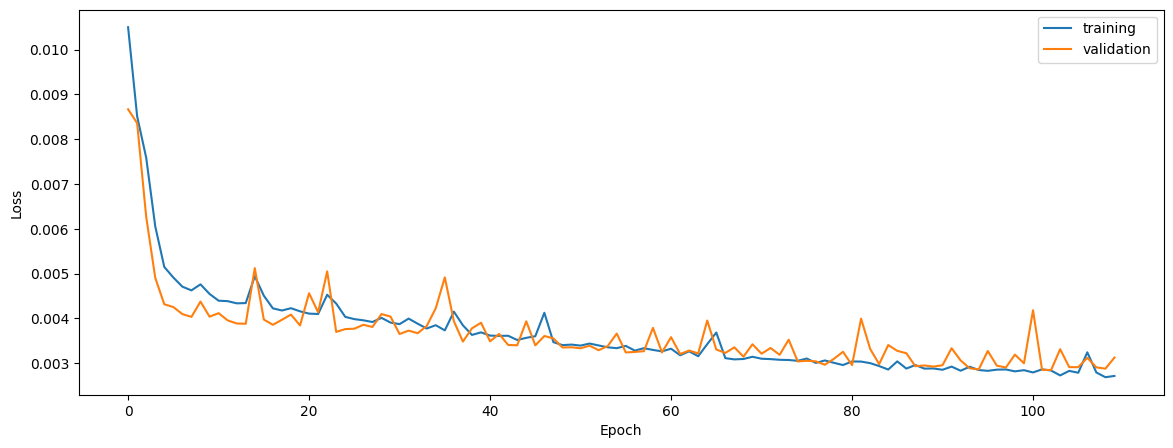

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8300296353252801
0.8223118645987566
0.8246782493136149


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8300296353252801
0.8223118645987566
0.8246782493136149


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8223119054731356
0.8220492606443224
0.8069265227805384


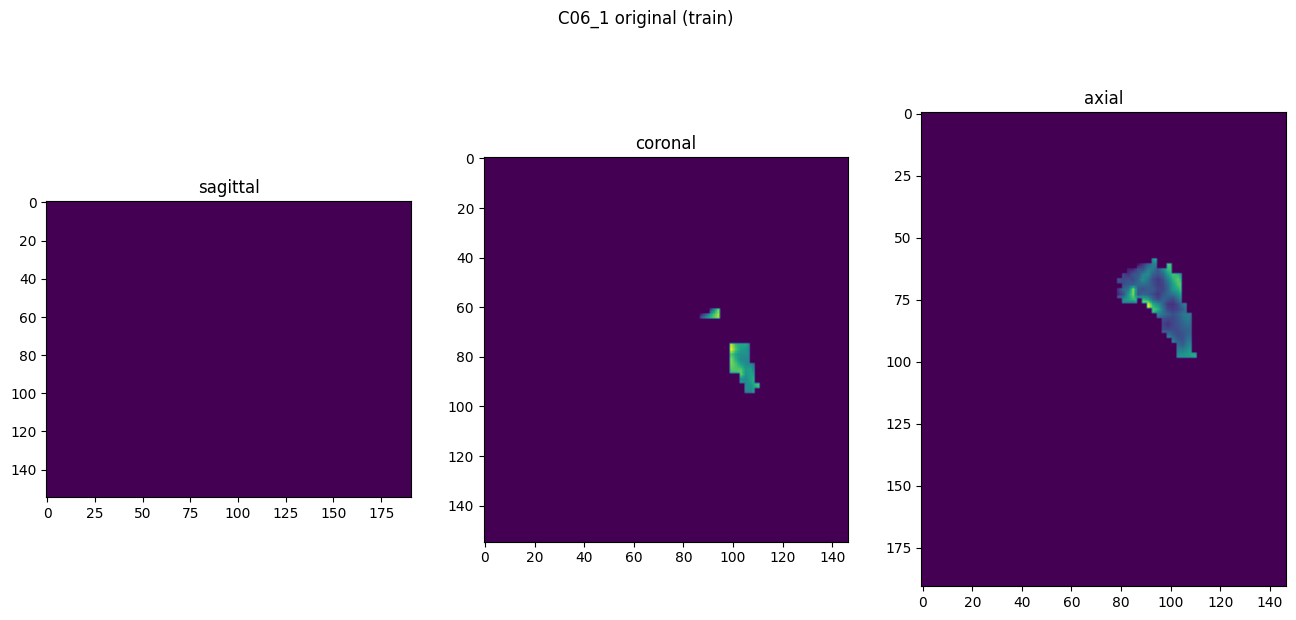

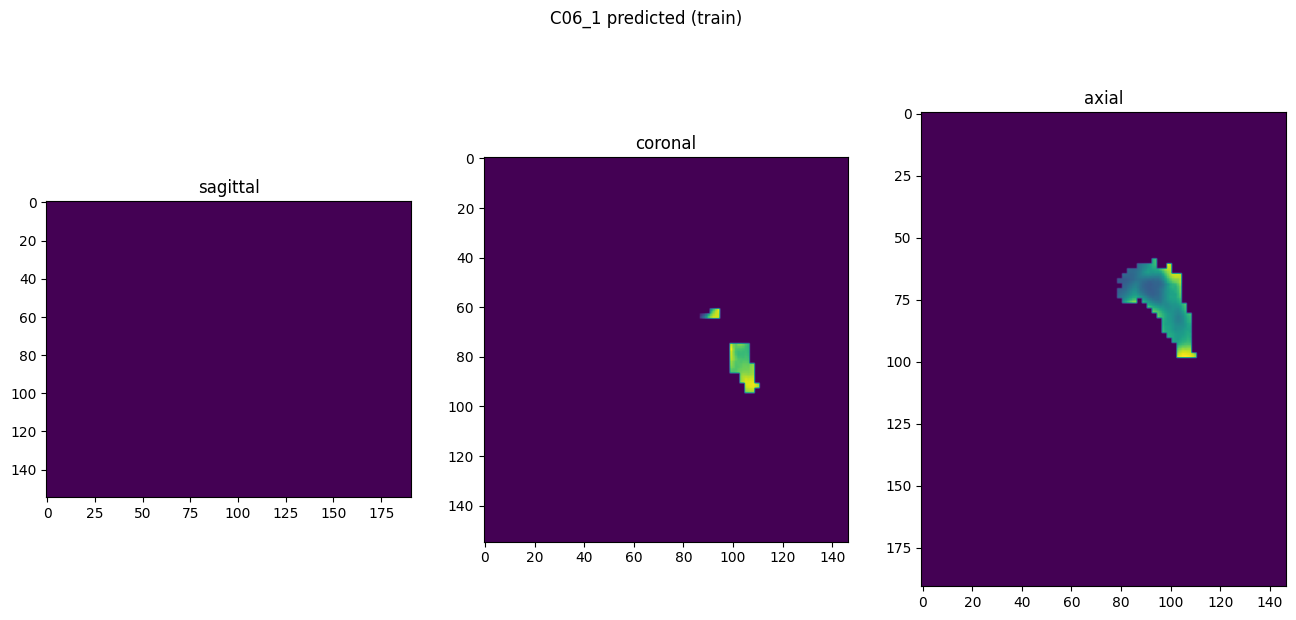

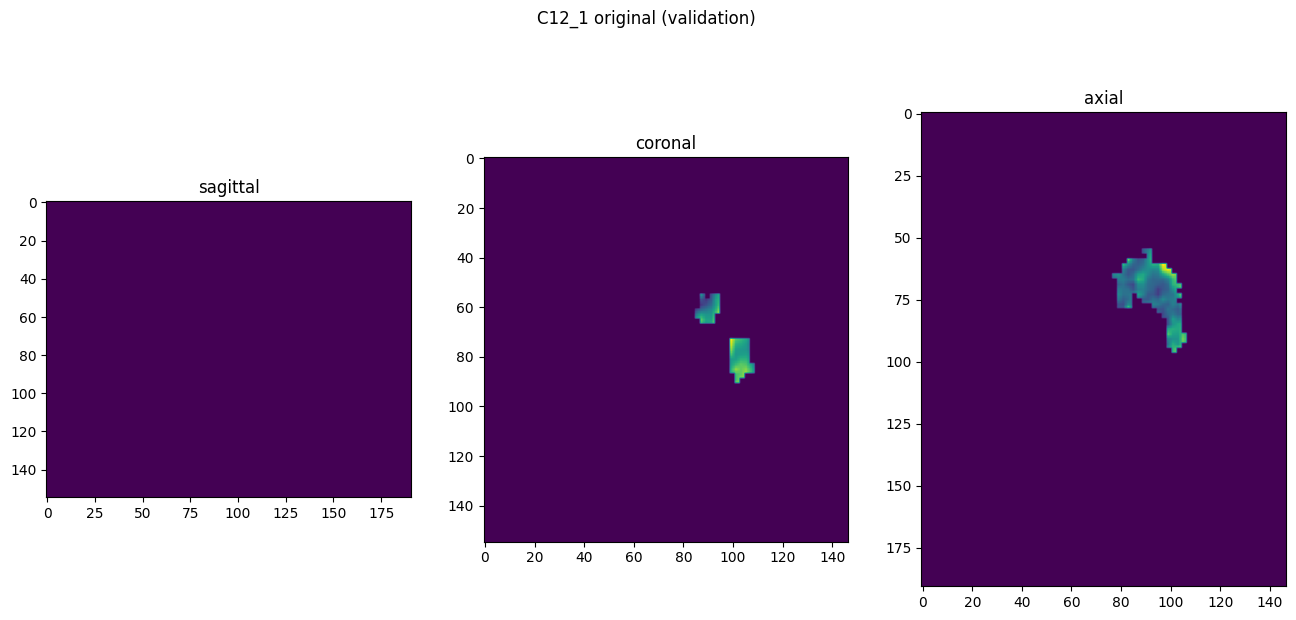

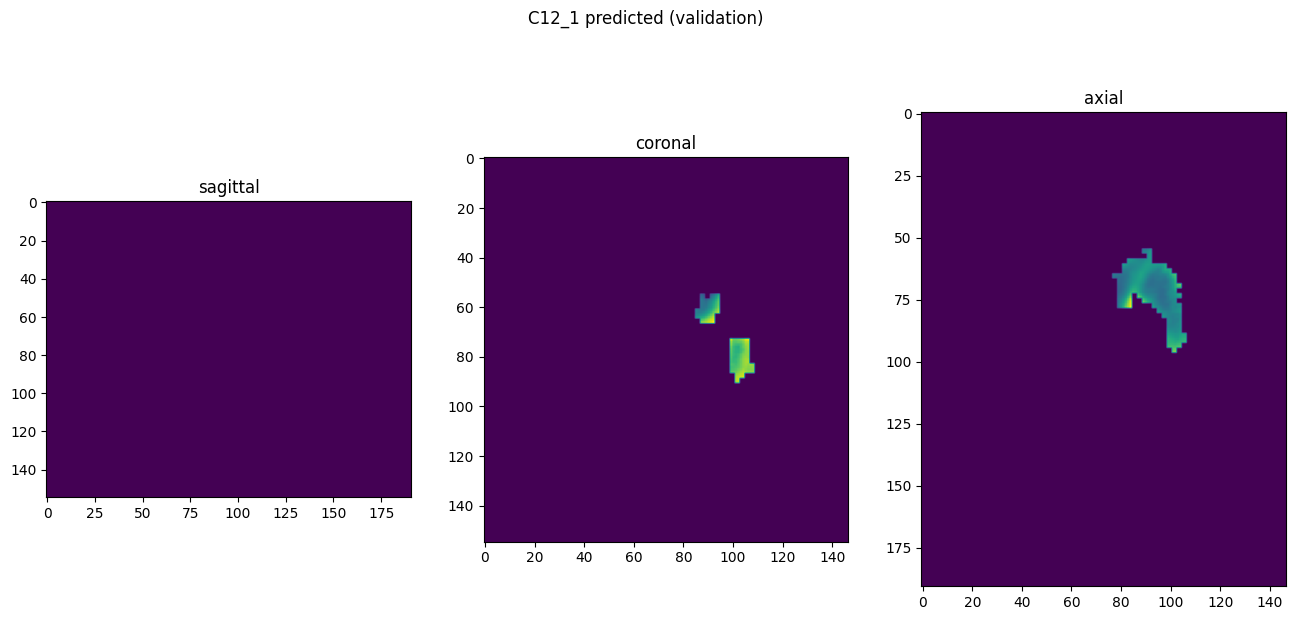

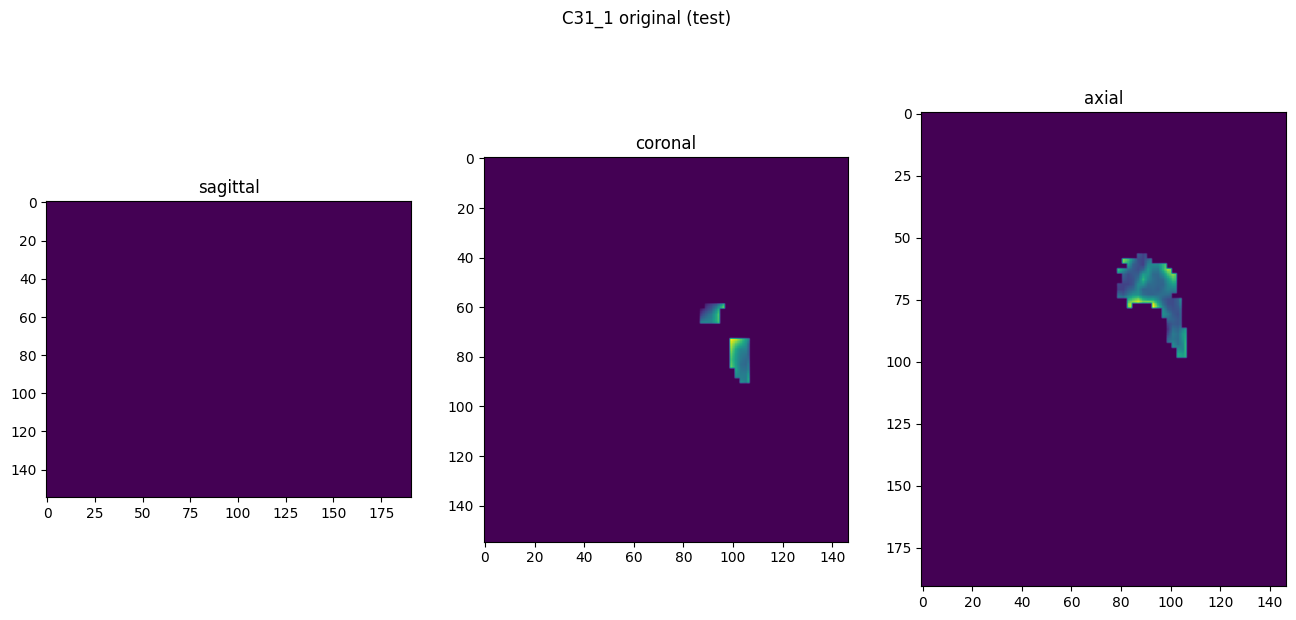

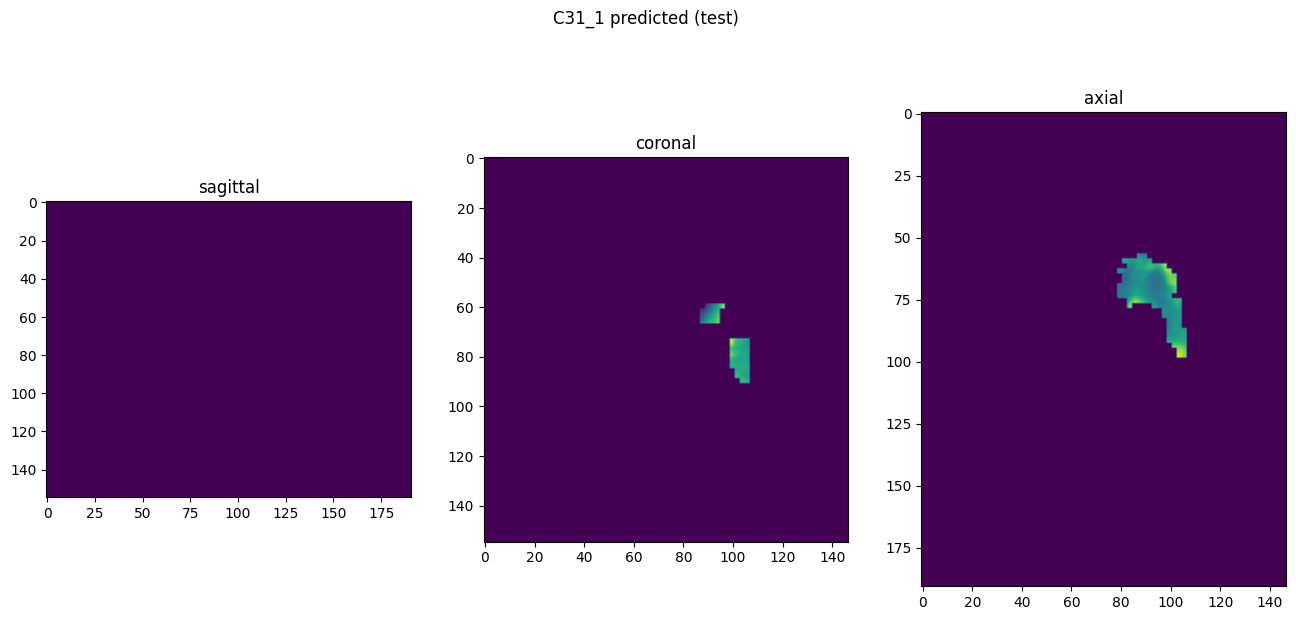

In [10]:
showResults(model, gen, threshold=None, background=False)